<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Attention and Transformers

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

---

**Each assignment is graded out of 5 points.  The topic for this assignment is Transfer Learning for Text.**

**Due:** 11/03/2020 10:15 AM EDT

**Submit:** We won't be re running your notebooks, please ensure output is visible in the notebook.

#### Learning Objectives

In this exercise you will cover the following topics:  
- Tokenizing text for BERT
- BERT for Text Classification Task

---

#### Installs

In [ ]:
!pip install transformers #Installing Huggingface transformers 

#### Imports

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
from string import Template
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

#### Verify Setup

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Utils

In [ ]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

## Dataset

**We will continue to use the dataset from Exercise 6.** The dataset consists of news articles from CNN in the politics, health, and entertainment category. There are about 300 articles in each category.

#### Download

In [ ]:
start_time = time.time()
download_file("https://storage.googleapis.com/dataset_store/ac295/news300.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.003805375099182129


#### Explore

In [ ]:
data_dir = os.path.join("datasets","news300")
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Load the text content
for idx, path in enumerate(data_x):
  # Load text
  with open(path) as file:
    data_x[idx] = file.read()

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])
print("Label counts:",np.unique(data_y, return_counts=True))

Number of classes: 3
Labels: ['politics', 'entertainment', 'health']
data_x count: 920
data_y count: 920
['Romney cites Trump\'s rhetoric as he denounces \'vile\' state of American politics Washington (CNN)Republican Sen. Mitt Romney of Utah on Tuesday issued a strong rebuke of the current tone of American politics saying they have become "a vile, vituperative, hate-filled morass" and roundly criticizing President Donald Trump for several of his recent comments which included insulting Democratic vice presidential nominee Kamala Harris. "I\'m troubled by our politics, as it has moved away from spirited debate to a vile, vituperative, hate-filled morass that is unbecoming of any free nation -- let alone the birthplace of modern democracy," Romney, the 2012 Republican presidential nominee, wrote in a statement in which he also called out Democrats for their own behavior and rhetoric. "The President calls the Democratic vice presidential candidate \'a monster;\' he repeatedly labels the s

#### View Text

In [ ]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Label:",data_y[data_idx],", Text:",data_x[data_idx])

Label: health , Text: US has more known cases of coronavirus than any other country  (CNN)The United States now has the highest number of known cases of coronavirus in the world with more than 82,000, according to CNN's tally of cases reported by health officials. The US cases piled up Thursday, surpassing China and Italy. The per capita rate of cases varies because of the countries' vast differences in population.  As of Thursday evening, the United States had at least 82,100 cases while China was reporting 81,782. There have been more than 510,000 cases reported worldwide. The countries' numbers are changing constantly and both the totals and the rank order of countries could change at any time. The grim milestone comes just as US officials said there was a new high for fatalities reported in a single day. At least 246 new deaths were reported Thursday, bringing the total number of deaths nationwide to at least 1,195. The spike of cases has hospitals around the country scrambling to 

## Questions:

For this exercise you will use a transformer model **BERT** that was discussed in lecture. [Hugging Face](https://huggingface.co/) is an NLP-focused company with a large open-source library especially around the Transformers. They provide the transformers library that exposes an API to use many well-known transformer architectures, such as BERT, RoBERTa, GPT-2 or DistilBERT, that obtain state-of-the-art results on a variety of NLP tasks like text classification, information extraction, question answering, and text generation. These architectures come pre-trained with several sets of weights. Getting started with Transformers only requires to install the `pip install transformers`

You will use BERT direclty from the transformers package


## Question 1 : Build a text classification model using BERT (3.0 Points)

#### a) Prepare data for BERT

BERT requires the data to be tokenized in a specific way, for this you need to use the `BertTokenizer` from the `transformers` package from Hugging Face. Steps to prepare your dataset:

- Split data to train/validation
- Use `BertTokenizer` to tokenize the input text
- [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer), use `bert-base-uncased` as the `vocab_file` argument
- When using `tokenizer.encode_plus(...)` use the `max_length=256` or some value `<=512`. You may run into OOM error during training if the value is high
- The output tokens from `tokenizer.encode_plus(...)` is a dictionary with the keys `'input_ids', 'token_type_ids', 'attention_mask'`
- Remember to convert the data y values `to_categorical`
- Create TF Datasets using the tokenized results. When using `tf.data.Dataset.from_tensor_slices(...,...)` look out for the x values passed in. `BERT` requires 3 inputs `'input_ids', 'token_type_ids', 'attention_mask'` as a tuple.
- Remember to apply `shuffle(..)` `batch(...)` `prefetch(..)` to your train and validation data

In [ ]:
# Examples on how to use the BertTokenizer

tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

# Tokenizer encode_plus
text = "What you need to know about using them safely amid the pandemic"
outputs = tokenizer.encode_plus(text, 
                  add_special_tokens = True, # add [CLS], [SEP]
                  max_length = 15, # max length of the text that can go to BERT (<=512)
                  padding='max_length',
                  return_attention_mask = True, # add attention mask to not focus on pad tokens
                  truncation='longest_first',
                  return_tensors="tf"
              )
print("Tokenizer Output:",outputs)

# Tokenizer batch_encode_plus
text = ["What you need to know about using them safely amid the pandemic", 
        "A third of Medicare enrollees with coronavirus ended up in the hospital"]
outputs = tokenizer.batch_encode_plus(
        text,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=15, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )
print("Tokenizer Output:",outputs)
print("Tokenizer Output Keys:", outputs.keys())

Tokenizer Output: {'input_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
Tokenizer Output: {'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102],
       [  101,  1037,  2353,  1997, 27615, 25612, 10285,  2007, 21887,
        23350,  3092,  2039,  1999,  1996,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dt

In [ ]:
# Split data to train/validation
validation_percent = 0.20

train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

# Use BertTokenizer to tokenize the input text
# BertTokenizer, use bert-base-uncased as the vocab_file argument
# When using tokenizer.encode_plus(...) use the max_length=256 or some value <=512. You may run into OOM error during training if the value is high
# The output tokens from tokenizer.encode_plus(...) is a dictionary with the keys 'input_ids', 'token_type_ids', 'attention_mask'
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
train_x = tokenizer.batch_encode_plus(train_x, 
                  max_length = 512, # max length of the text that can go to BERT (<=512)
                  padding='max_length',
                  add_special_tokens = True, # add [CLS], [SEP]
                  return_attention_mask = True, # add attention mask to not focus on pad tokens
                  truncation='longest_first',
                  return_tensors="tf"
              )

validate_x = tokenizer.batch_encode_plus(validate_x, 
                  max_length = 512, # max length of the text that can go to BERT (<=512)
                  padding='max_length',
                  add_special_tokens = True, # add [CLS], [SEP]
                  return_attention_mask = True, # add attention mask to not focus on pad tokens
                  truncation='longest_first',
                  return_tensors="tf"
              )







In [ ]:
# Datatset Params
batch_size = 8 # You can try higher values but may run into OOM errors depending on which GPU you are using
train_shuffle_buffer_size = 800
validation_shuffle_buffer_size = 200

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='int32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='int32')
# Converts to y to_categorical

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((dict(train_x) , train_processed_y))
train_data = train_data.shuffle(train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=100)

# validation_data = tf.data.Dataset.from_tensor_slices(((validate_x['input_ids'],validate_x['token_type_ids'],validate_x['attention_mask']) , validate_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((dict(validate_x) , validate_processed_y))
validation_data = validation_data.shuffle(validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=100)
print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 3)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>
validation_data <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 3)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>


Your train and validation dataset should look something like this
```
print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ({input_ids: (None, 256), token_type_ids: (None, 256), attention_mask: (None, 256)}, (None, 3)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>
validation_data <PrefetchDataset shapes: ({input_ids: (None, 256), token_type_ids: (None, 256), attention_mask: (None, 256)}, (None, 3)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>
```

#### b) BERT for Sequence Classification

- Build a model using `TFBertForSequenceClassification` from the `transformers` package from Hugging Face
- Load the pre-trained weights using `bert-base-uncased` make sure to pass the argument `num_labels`
- Train your model
- Ensure there is a plot of your training history

In [ ]:
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes,
    output_hidden_states=False,
    output_attentions=False
)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
92/92 [==============================] - 104s 1s/step - loss: 0.5003 - accuracy: 0.8601 - val_loss: 0.3876 - val_accuracy: 0.8967
Epoch 2/10
92/92 [==============================] - 101s 1s/step - loss: 0.1318 - accuracy: 0.9674 - val_loss: 0.2599 - val_accuracy: 0.9239
Epoch 3/10
92/92 [==============================] - 101s 1s/step - loss: 0.1058 - accuracy: 0.9715 - val_loss: 0.3026 - val_accuracy: 0.9239
Epoch 4/10
92/92 [==============================] - 101s 1s/step - loss: 0.0432 - accuracy: 0.9905 - val_loss: 0.2473 - val_accuracy: 0.9511
Epoch 5/10
92/92 [==============================] - 101s 1s/step - loss: 0.0449 - accuracy: 0.9864 - val_loss: 0.3652 - val_accuracy: 0.9185
Epoch 6/10
92/92 [==============================] - 101s 1s/step - loss: 0.0516 - accuracy: 0.9837 - val_loss: 0.3260 - val_accuracy: 0.9130
Epoch 7/10
92/92 [==============================] - 101s 1s/step - loss: 0.0204 - accuracy: 0.9946 - val_loss: 0.2681 - val_accuracy: 0.9565
Epoch 8/10
92

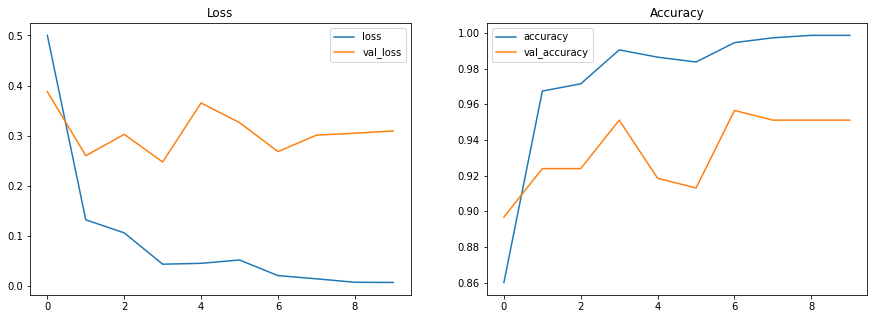

23/23 [==============================] - 7s 318ms/step - loss: 0.3094 - accuracy: 0.9511
Evaluation Results: [0.30937138199806213, 0.9510869383811951]


In [ ]:
############################
# Training Params
############################
learning_rate = 2e-5 # Try 5e-5, 3e-5, 2e-5
epochs = 5

# Free up memory
K.clear_session()

# Build BERT model
# model = ... 
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate, epsilon=1e-08)

# Loss
loss = losses.CategoricalCrossentropy(from_logits=True) 
# Compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train model
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=10,
        verbose=1)
# Evaluate 
evaluate_model(model,validation_data, training_results)

In [ ]:
# Taking which Semantic Segmentation with Transfer Learning Demo
def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

#### c) Classification Results

- What was your validation accuracy?
- It should be more that 95%

As you can see above, the validation accuracy is 95.11%, which is greater than 95.00%

---
## Question 2 : Conceptual (2.0 Points)


#### a) How does the encoder-decoder structure work for language modelling?


In a language model, the traditional encoder structure takes in a sequence and encodes that sequence into some laten space. The decoder is then responsible for decoding that sequence. For instance, if you are doing translation, the encoder is responsible for finding the latent significance of the sequence and the decoder is responsible for translating it.


#### b) Explain in your own words what is the attention mechanism. Why do State of the art models use this concept?

The attention mechanism is a way to represent the significance of every word in a sequence towards the meaning of each given word. For instance, if your sequence is "the dog barks", the attention vector for the word "bark" would also emphasize the word "dog", as the word "bark" has a number of very different meanings. Attention is an way to also pass in sequences in paralell and retain positional significance, whereas a traditional RNN would have to be trained serially, which is very slow, and any given word only has the context of the words that preceed it, which can sometimes negatively affect results.

#### c) What is the biggest benefit of transformers compared to seqtoseq models?

The biggest benefit of transformers vs seq2seq models is performance/paralellizibility. A transformer can take in a long sentence and still perform well, whereas the vanishing gradients in a conventional RNN would make that difficult, and training something like a LSTM is very slow. Meanwhile, a transformer can take in an entire sequence at once, which is much faster, and can still retain attention on much earlier portions of the sentence.

#### d) Explain in your own words what the positional encoder is and why it is needed?

Since you are passing everything to a transformer at once, it is important to represent the order of words in the input sequence. The positional encoder creates a vector in the intended dimensinoal space which represents this ordering and indicates where a given word appears in a sequence.